# Exploratory Data Analysis

___
In this notebook, all exploratory data analysis (EDA) was completed on the Bitcoin DataFrame that was previously cleaned. The components of EDA include a time plot, seasonal decomposition plot, stationarity check, and ACF/PACF charts. These various plots will help to determine which models are appropriate to forecast Bitcoin price.

In order for this analysis to be uniform with other financial analysis (quantitative analysis), closing price is the focus of analysis and forecasting. The choice to focus analysis on closing price is two-fold: closing price is the traditional way financial analysis is done on stocks and because Bitcoin never actully closes, tomorrow's open and today's close will be the exact same. The close is understood as 11:59 PM (UTC). Other price options (such as the high or low) could also be analyzed, but for coherence are not done at this time. 

## Table of Contents

- **[Import Libraries & DataFrame](#1)**
- **[Bitcoin Daily Closing Price Time Plot](#2)**
- **[Seasonal Decomposition](#3)**
- **[Stationarity Check](#4)**
- **[Autocorrelation Plots](#5)**
- **[Partial-autocorrelation Plots](#6)**
- **[Conclusion and Recommendations](#7)**

<a id="1"></a>
## Import Libraries & DataFrame

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as fplt
plt.style.use('fivethirtyeight')
%matplotlib inline

import statsmodels.api as sm
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
register_matplotlib_converters()

In [24]:
# import daily
daily = pd.read_csv('./data/daily_clean.csv')

In [25]:
# change date col to datetime and index in hourly & daily
daily['date'] = pd.to_datetime(daily['date'])

In [26]:
# set date col to index in daily
daily.set_index('date', inplace=True)

# sort by index
daily.sort_index(inplace=True)

In [27]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2895 entries, 2013-04-29 23:59:00 to 2021-04-01 00:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   high    2895 non-null   float64
 1   low     2895 non-null   float64
 2   open    2895 non-null   float64
 3   close   2895 non-null   float64
 4   volume  2891 non-null   float64
dtypes: float64(5)
memory usage: 135.7 KB


<a id="2"></a>
## Bitcoin Daily Closing Price Time Plot

___
This section will show a time plot of historical Bitcoin daily closing prices. The daily chart is from April 29, 2013, through April 1, 2021. 

The goal here is to see if any clear trend can be seen in the charts. If a clear linear or exponential trend can be seen, the data will need to be confirmed as not stationary then appropriately differenced. 

The daily chart will resample to show monthly and quarterly time plots in order to confirm any trends seen over longer time periods.

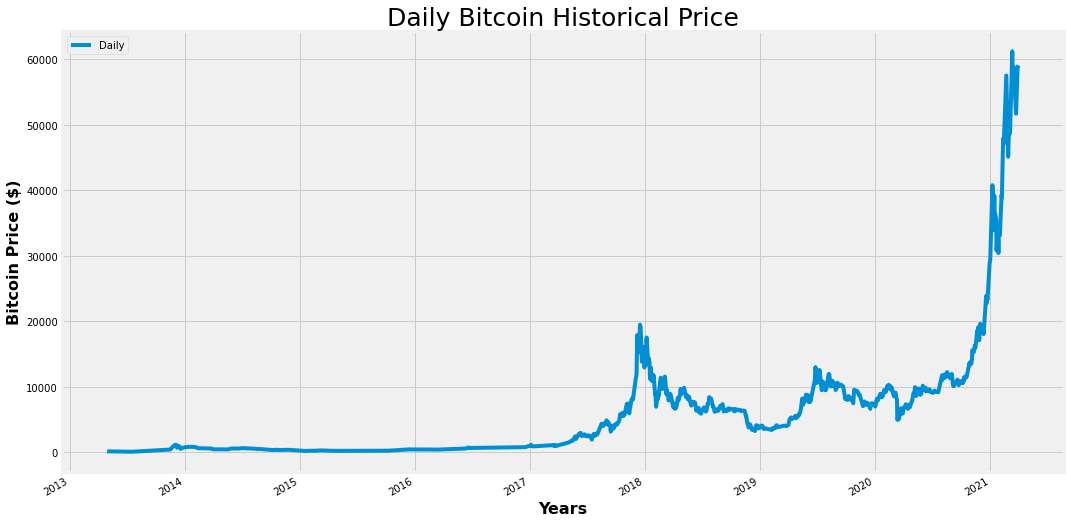

In [28]:
# set figsize
plt.figure(figsize=(16,9))

# plot the daily closing price
daily.close.plot(label='Daily')

# title/x/y labels
plt.title('Daily Bitcoin Historical Price', fontsize=25)
plt.xlabel('Years', fontsize=16)
plt.ylabel('Bitcoin Price ($)', fontsize=16)

# set legend
plt.legend();

In the Bitcoin closing price graph above there are a few key things to note: due to the large range in Bitcoin price, the graph looks as though there was no change in price from 2013 through 2017, an intial peak in 2017, no trend from late-2017 through late-2020, and finally the price broke out at the end of 2020. Bitcoin has been on a near vertical ascent in price ever since this last breakout took place. There is a positive trend in the data, a deeper analysis could help differentiate if this trend is linear or exponential. 

A deeper analysis into the longer-term trends could help differentiate between a linear or exponential trend.

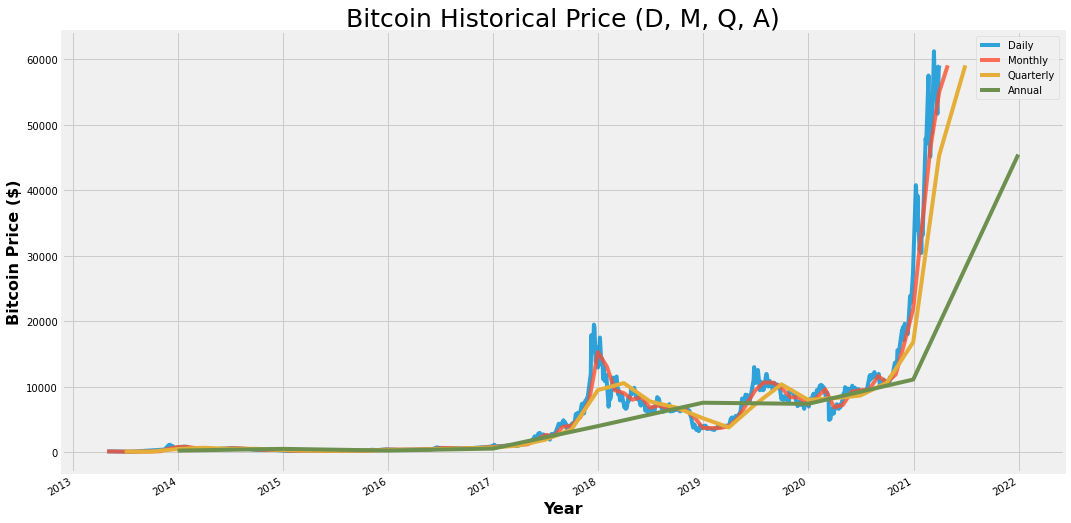

In [29]:
# set figsize
plt.figure(figsize=(16,9))

# daily close 
daily.close.plot(alpha=0.8, label='Daily')

# resample weekly, monthly, quarterly and annually
# remove weekly resample: it and monthly resample very close to daily close, not much info there
#daily.close.resample('W').mean().plot(alpha=0.8, label='Weekly')
daily.close.resample('M').mean().plot(alpha=0.8, label='Monthly')
daily.close.resample('Q').mean().plot(label='Quarterly')
daily.close.resample('Y').mean().plot(label='Annual')

# title/x/y axis
plt.title('Bitcoin Historical Price (D, M, Q, A)', fontsize=25)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Bitcoin Price ($)', fontsize=16)

# set legend
plt.legend();

The choice to analyze weekly, monthly, quarterly, and annual Bitcoin closing prices was an attempt to better gauge the trend in closing price. The data appears to have an exponential trend even when looking at the annual resampling of data. This gives credence for an exponential smoothing model to be explored.

Next a seasonal decomposition plot will be run on the data in order to do a further analysis on the trend, seasonality, and residual values. 

Before leaving this section, the next graph shows the daily closing price of Bitcoin as a candlestick chart and include the 50-day moving average. This is a common view of a daily stock chart with this moving average, another common moving average in the daily charts is the 200-day moving average but it is not included below for simplicity.

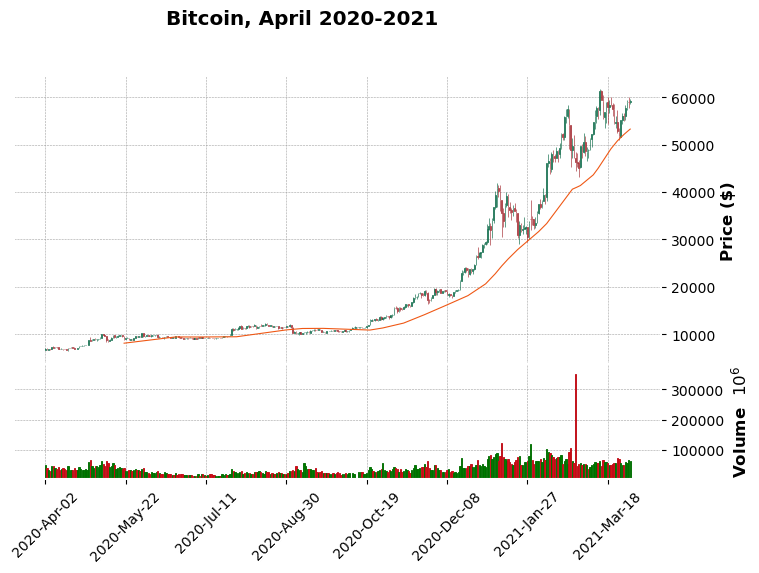

In [30]:
## daily closing price candlestick chart with moving averages
fplt.plot(daily[-365:], # show the last year's worth of bitcoin daily trading ranges
          type='candle', # set candlestick chart
          style='charles', # style the chart with color
          volume=True, # show volume of trading day
          mav=(50), # set 50 day moving averages
          title='Bitcoin, April 2020-2021', # set title
#          savefig='./images/bitcoin_april_2020_2021', # this code was commented out after the image was saved
          figratio=(25,16), # set figsize
          ylabel='Price ($)') # set ylabel

The candlestick chart above is meant to show Bitcoin's price in a more financial environment. Unfortunately, even in the one-year view above it is difficult to see the full benefits of a candlestick chart. Below is just the final week of Bitcoin price action to better see how each candlestick shows the open, close, high, and low of the trading session. The hash marks at the top and bottom of each candlestick show the high and low respectively. The box area is the open and close: open is at the bottom if the candle is green, and it is at the top if the candle is red.

The addition of the volume chart at the bottom is an indication of how many trades took place on that day. This is a helpful indicator to understand if the price movement is significant (high volume) or insignificant (low volume). This is based on stock trading principals, however there is some merit to stock principals within the realm of Bitcoin.

Another stock trading principal regards the moving averages. A very common moving averages for a daily stock chart is the 50-day moving averages. This lines simply show the average closing price over the period (50 days). There is a principal regarding moving averages that says these lines can be areas of support (price holds above) or resistance (price unable to break higher). 

From December 8, 2020 through April 2021, Bitcoin price successfully tested the 50-day moving average four times and held above this line. This is a signal that the 50-day moving average can be treated as a line of support and could be treated as a buy area whenever the price is approaching this line. The other side of this principal is that once the price breaks below the line of support, this line will become resistance (meaning Bitcoin may have a hard time breaking back above the line once it breaks below it).

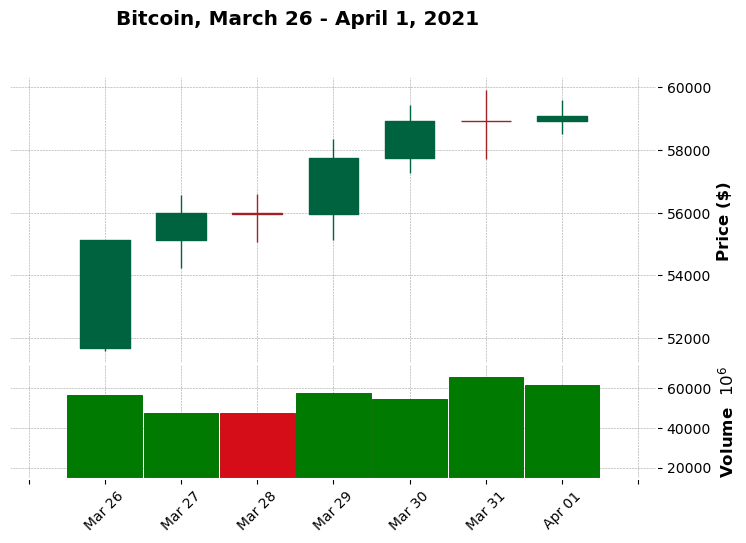

In [31]:
# 7 days of bitcoin price action to view candlestick
fplt.plot(daily[-7:], # show the last year's worth of bitcoin daily trading ranges (needs to be above 200 for 2nd MA)
          type='candle', # set candlestick chart
          style='charles', # style the chart with color
          volume=True, # show volume of trading day
          title='Bitcoin, March 26 - April 1, 2021', # set title
          figratio=(25,16), # set figsize
          ylabel='Price ($)') # set ylabel

<a id="3"></a>
## Decompose the Data

___
In this section a function will be created to decompose the data. The choice to use `seasonal_decompose` stems from an efficiency perspective, the function breaks the data into four key components: observed, trended, seasonal, and residual. Each of these components will be discussed in detail when interpreting the plots.

In [32]:
# create a function that will show seasonal_decomposition chart in different time periods/frequencies 
# this is code that was created in a previous project but is being reused here
# link to previous project: https://github.com/qghaemi/ga_project_5/blob/main/2_eda.ipynb
def seasons(y, n, title, model='additive'):
    
    # call the seasonal_decompose method based on data
    # chose to leave y as an input to be able to change col
    decomposition = seasonal_decompose(y, period=n, model=model)
    
    # plot the decomposition
    fig = decomposition.plot()
    
    # set figsize title and show
    fig.set_size_inches(14,7)
    plt.title(title)
    plt.show()

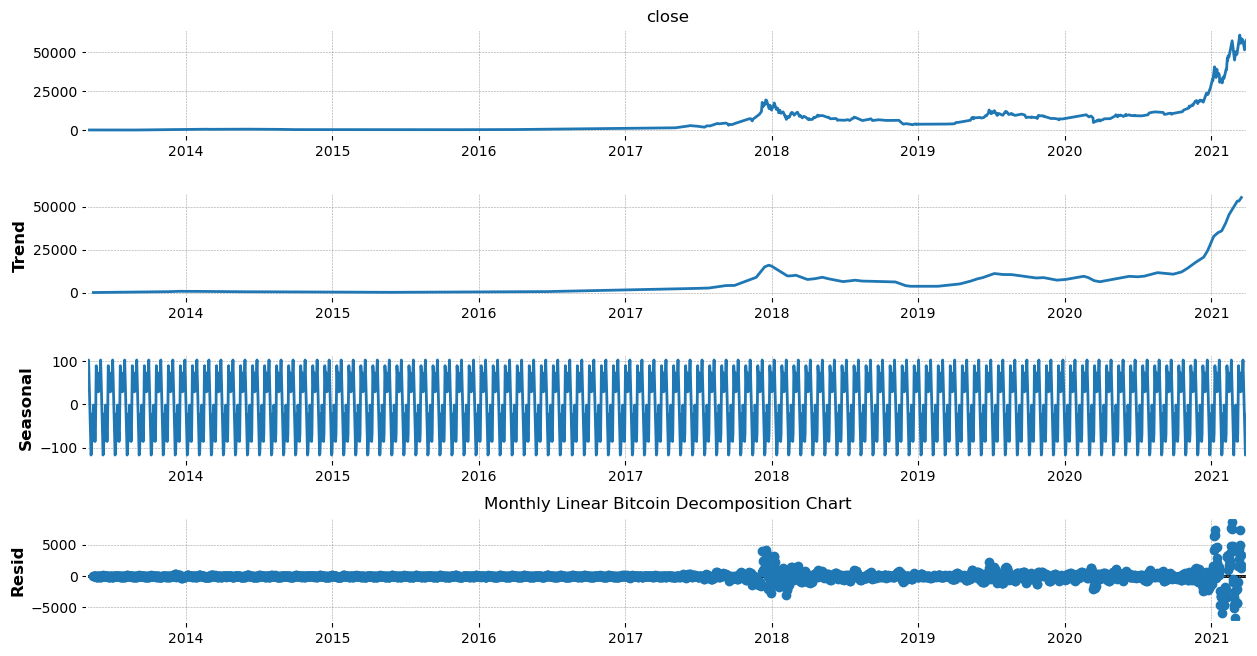

In [33]:
# daily close / monthly w linear trend
seasons(daily['close'], 30, 'Monthly Linear Bitcoin Decomposition Chart')

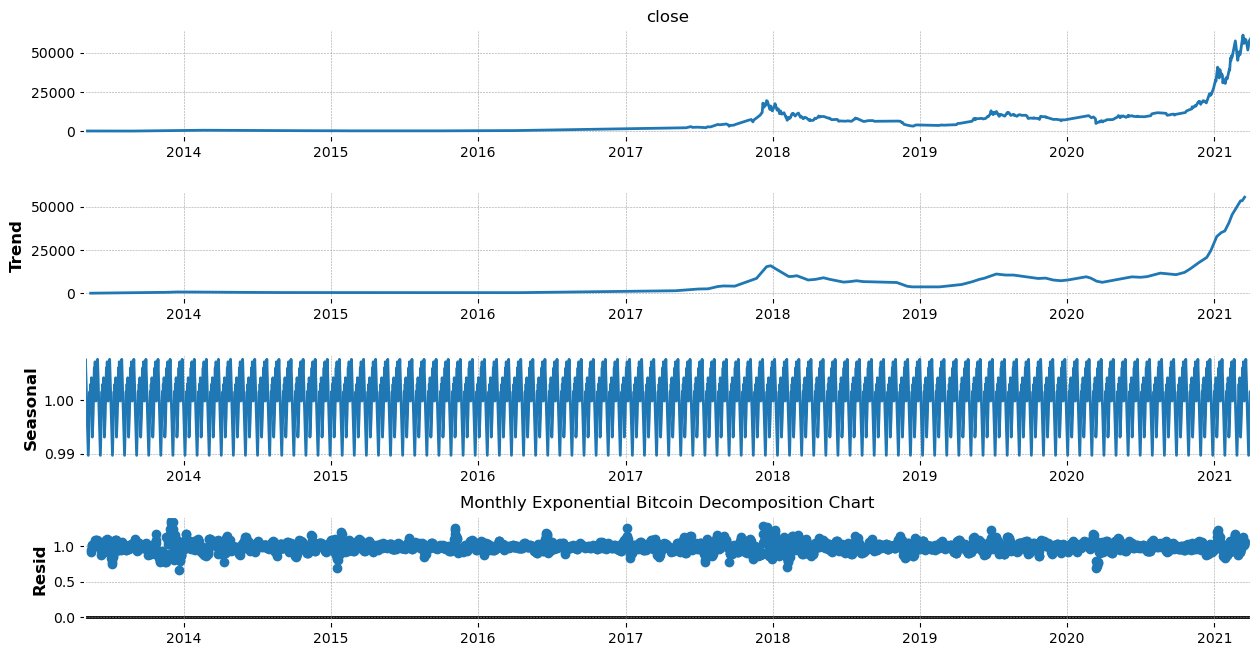

In [34]:
# call seasonal_decompose on the daily closing data / monthly with an exponential trend
seasons(daily['close'], 30, 'Monthly Exponential Bitcoin Decomposition Chart', 'multiplicative')

The seasonal decomposition chart is made up of four sections from top to bottom: time plot, trend analysis, seasonality analysis, and residuals. Above is a seasonal decomposition of Bitcoin's closing price every 30-days.

The time plot, trend analysis, and seasonality analysis are identical for the two charts above. The time plot and trend are no different than the time plot in the previous section with the monthly resample. The third graph: seasonal, shows there is seasonality seen at the monthly level. There was no seasonality seen at a weekly level so that graph is not shown.

The key difference between the two seasonal decomposition charts above is the 'multiplicative' keyword argument used for the second chart. The two keyword options are 'additive' and 'multiplicative' and they signal to the computer that the trend is either linear or exponential respectively. 

In order to better analyze the trend data, the two seasonal decomposition charts show linear and exponential trend respectively. The residual values are where these differences can be seen. In the linear chart (top) shows little residual values until 2018, then become more pronounced again in 2021. This differs from the exponential chart that shows residual values of significance from beginning to end. 

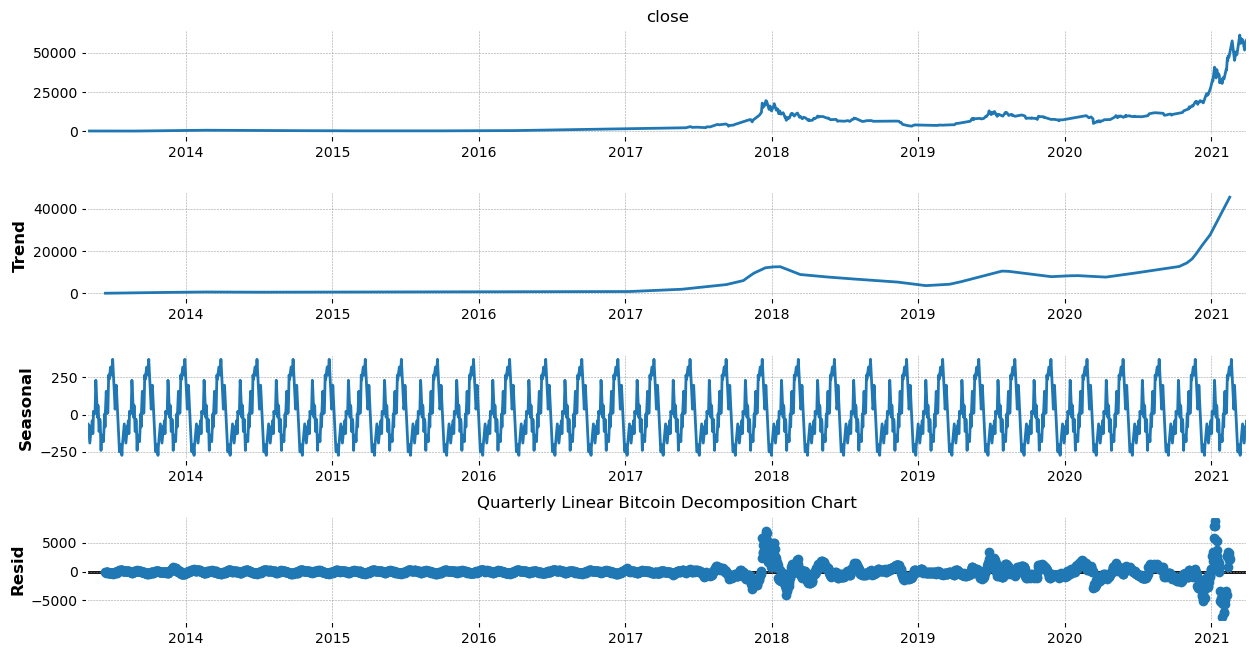

In [35]:
seasons(daily['close'], 90, 'Quarterly Linear Bitcoin Decomposition Chart')

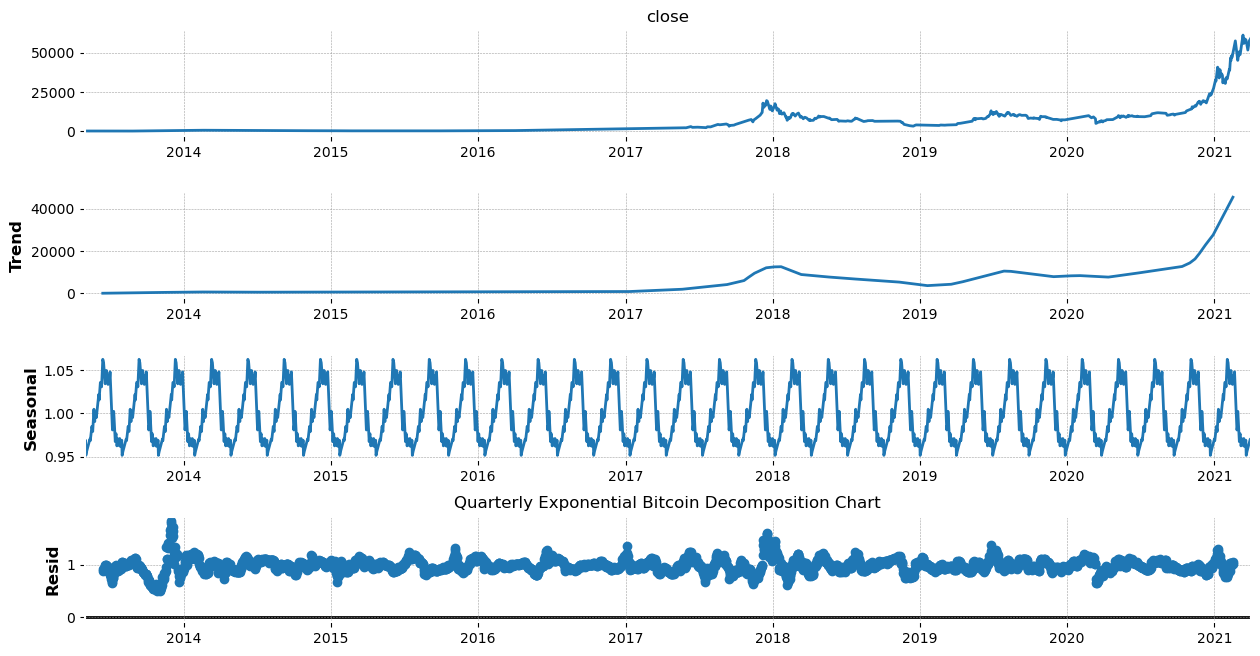

In [36]:
seasons(daily['close'], 90, 'Quarterly Exponential Bitcoin Decomposition Chart', 'multiplicative')

The modeling portion of the project will be focused on forecasting Bitcoin price in the next quarter which led to expanding the seasonal period to 90 days. 

Much of what is seen in the 90-day seasonal decomposition charts are seen in the 30-day seasonal decomposition charts: time plot is the same, trend plot is the same as the quarterly resampled time plot, there is seasonality at the 90-day level (it is more pronounced than at 30-days), and the residual plot of the linear model there is little change in value until 2018, but in the exponential model the residual values are present throughout.

While deeper exploration will be done, there are two possible explanations for this residual change: there is a linear trend in the data until 2018, then the trend shifts to exponential; or the trend was always exponential because the choppiness in residuals was more-or-less consistant throughout. 

In order for the first explanation to be valid, there would need to be some change in the underlying technology around 2018; the underlying technology of Bitcoin has not been changed since its inception. One could argue that Bitcoin's first attempt at mainstream notority coincided with this time period, but that was caused by the price increase (not the other way araound). This is a key differentiator in estalishing that Bitcoin's price movement has an exponential trend.

Despite establishing that there is an exponential trend, one more seasonal decomposition chart was done to analyze trends on a semi-annual basis. The thought process here was to confirm the findings in the residual chart.

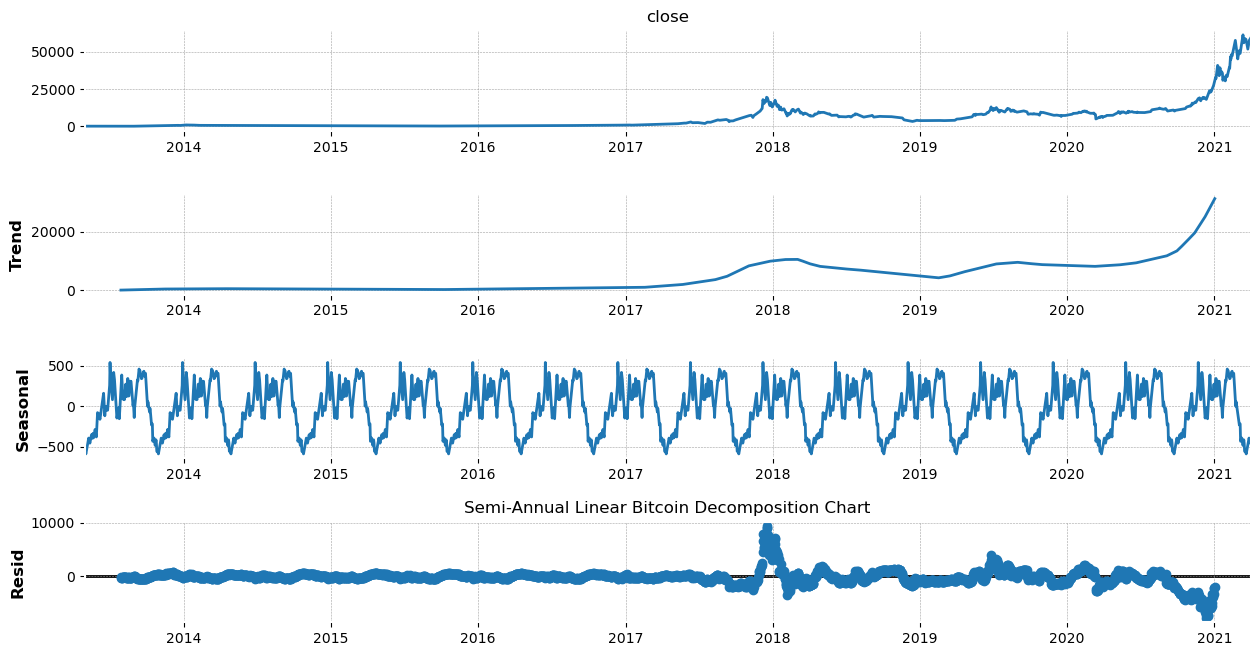

In [37]:
seasons(daily['close'], 180, 'Semi-Annual Linear Bitcoin Decomposition Chart')

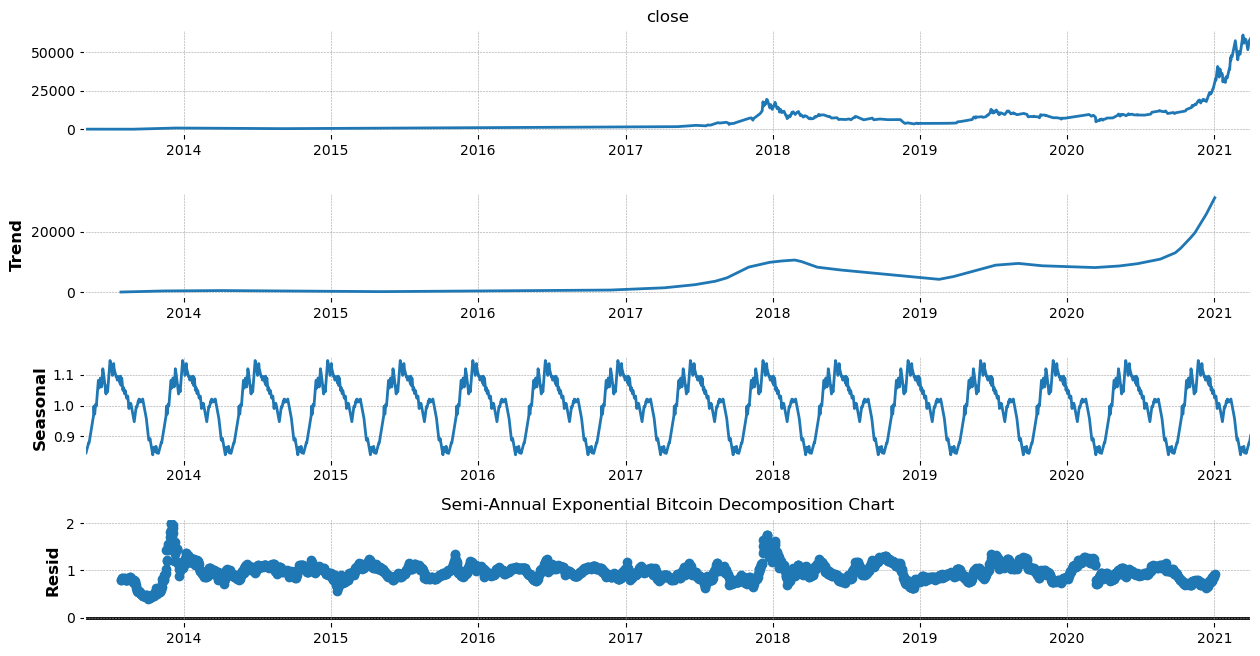

In [38]:
seasons(daily['close'], 180, 'Semi-Annual Exponential Bitcoin Decomposition Chart', 'multiplicative')

The final seasonal decomposition charts follow the same pattern as seen before: time plot, trend, and seasonality are all the same or saying the same thing. 

The residual chart is very telling: at each time interval, the residual chart became more pronounced for the exponentially trended data vs. the linearly trended data; however, the residuals near the end of the time series were less volatile in the exponentially trended data. As previously established, the trend is most likely exponential and not a split/changing trend. 

The next section will explore stationarity in the data and how many differencing intervals are required to gain stationarity. By concluding the data has trended exponentially, it is worth exploring a logistic difference for modeling.

<a id="4"></a>
## Check For Stationarity


___
When forecasting time-series data it is important for all the data to be stationary. What this means is that the data should not change over time: the mean, variance, and autocorrelation should stay the same. Most time-series data (like stock/commodity/Bitcoin prices) are not stationary, these prices fluctuate and move higher/lower over the years.

When forecasting time-series data, most forecasting models are unable to properly forecast unless the data is made stationary. Stationarity removes trends from the dataset which can be extremely intrusive to our models; stationarity makes our models perform and predict better.

This section will check for stationarity both visually and with the Augmented Dickey-Fuller Test. The data is being tested with a 95% confidence level as that is standard. 

#### Visualization

---
This section builds a helper function to more easily plot the Bitcoin price and appropriate tests of mean and variance (standard deviation). 

The monthly, quarterly, and semi-annual means were used as these were the time periods checked in the seasonal decomposition charts and all three signaled an expoenntial trend. Only the quarterly standard deviation was plotted to avoid too many lines on one chart and given the model is meant to forecast a quarter out, it was the most appropriate time-length to confirm stationarity.

In [39]:
# create a function that can be reused on differenced data
def stationarity_visualizer(val, label, title):
    # set figsize
    fig, ax = plt.subplots(figsize=(16, 4))

    # plot closing price
    ax.plot(val, label= label, alpha=0.7)

    # plot the mean at the monthly, quarterly, and semi-annual levels
    ax.plot(pd.Series(val).rolling(window=30).mean() , label='30 Day Moving Average')
    ax.plot(pd.Series(val).rolling(window=90).mean() , label='90 Day Moving Average')
    ax.plot(pd.Series(val).rolling(window=180).mean() , label='180 Day Moving Average')

    # plot the std
    ax.plot(pd.Series(val).rolling(window=100).std(), label='90 Day Standard Deviation')

    # title/x/y labels
    plt.title(title, fontsize=22)
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Price ($)', fontsize=16)

    # legend
    ax.legend();

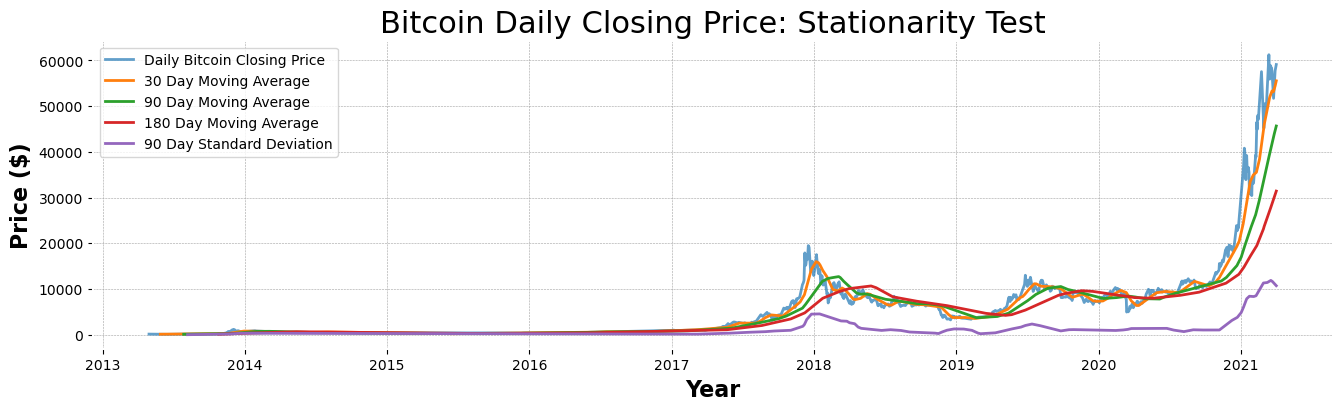

In [40]:
stationarity_visualizer(daily['close'], 
                        'Daily Bitcoin Closing Price', 
                        'Bitcoin Daily Closing Price: Stationarity Test')

In the above graph, the mean (30, 90, 180-day moving averages) and standard deviation both show significant changes over time suggesting the data is not stationary. A key takeaway here should be that even the 180-day mean saw an exponential trend that began at the end of 2020. This further confirms what was established previously that the trend is most likely exponential.

Performing an Augmented Dickey-Fuller Test should confirm the data is not stationary.

#### Augmented Dickey-Fuller Test

---
This section builds a helper function that will print and explicitly say what the P-value of the data is. If the P-value is greater than 0.05 then the data is not considered stationary. This 0.05 threshold stems from the 95% confidence interval: if this was being measured with a 99% confidence interval then the P-value would need to be less than 0.01.

In [41]:
# build a function to perform ADF test 
def adf_test(timeseries):
    
    # run ADF test
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    
    # print t-statistic and p-value
    print(f'Test statistic = {dftest[0]}')
    print(f'P-value = {dftest[1]}')
    
    # print confidence intervals and if data is stationary in those intervals
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [42]:
# non-differenced daily df
adf_test(daily['close'])

Test statistic = 5.337088517852609
P-value = 1.0
Critical values :
	1%: -3.4326329314838997 - The data is not stationary with 99% confidence
	5%: -2.862548643765697 - The data is not stationary with 95% confidence
	10%: -2.5673069305091714 - The data is not stationary with 90% confidence


Based on the AD-Fuller test, the P-value is 1. For data to be stationary, the P-value should be below 0.05 at minimum: this is based on the confidence interval being set to 95%. The lower the P-value the better. 

To get the P-Value to an appropriate level the data will be differenced. Differencing takes the data from one observation and calculates the difference in price based on the time period that is determined. This is one of the most common ways to achieve stationarity in the data.

The data has been previously established as exponentially trending. A normal differencing and logarithmic differencing will be applied in order to see which will provide a lower P-value.

In [43]:
# simple one period differencing on hourly data
adf_test(daily['close'].diff(1).dropna())

Test statistic = -8.351219672817424
P-value = 2.991085783185121e-13
Critical values :
	1%: -3.4326345265846516 - The data is  stationary with 99% confidence
	5%: -2.862549348242229 - The data is  stationary with 95% confidence
	10%: -2.5673073055685 - The data is  stationary with 90% confidence


After a simple, one-period differencing, the daily Bitcoin closing price data is stationary and the P-value would work on a confidence level of 99%. Based on this finding, the data will need to be differenced once in order to properly forecast. Another differencing test will be done, this time on logged values due to the exponential trend of the data. Once completed, both of these differenced datasets will be visualized again in order to confirm the mean and variance are not changing over time.

In [44]:
# Converting the data to a logarithmic scale
daily_bc_log = pd.DataFrame(np.log(daily.close))

# Differencing the log values
log_diff = daily_bc_log.diff(1).dropna()

In [45]:
adf_test(log_diff['close'])

Test statistic = -10.139274314406688
P-value = 8.505115709515392e-18
Critical values :
	1%: -3.4326297479554624 - The data is  stationary with 99% confidence
	5%: -2.86254723775867 - The data is  stationary with 95% confidence
	10%: -2.567306181959156 - The data is  stationary with 90% confidence


After completing a logarithmic difference, the P-value decreases even more than the simple differencing. This would indicate that the logged difference makes the data even more stationary. 

Both of these differenced datasets will be visualized again in order to confirm the mean and variance are not changing over time.

#### Visualizing Stationary Data

___
This section will show visualize the differenced data to show what stationary data looks like.

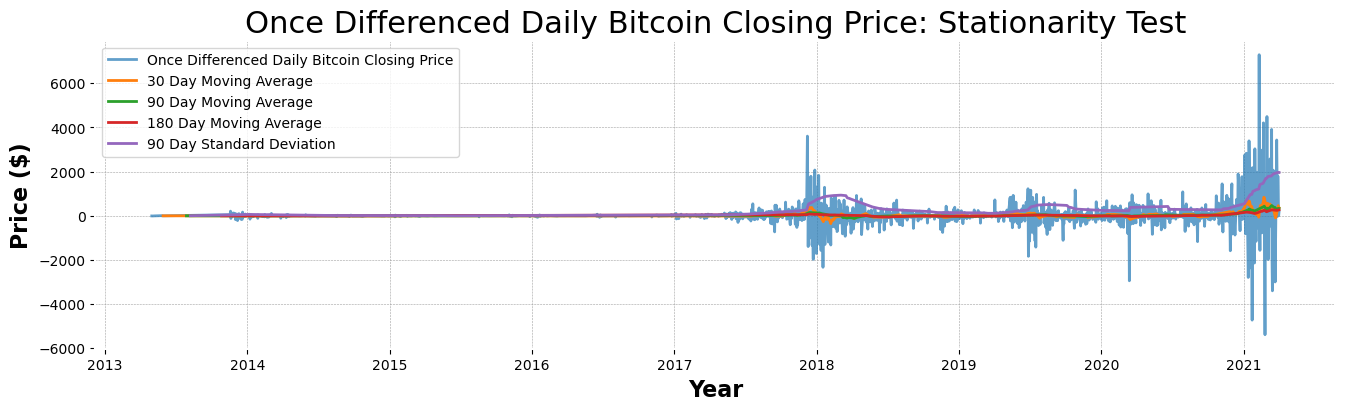

In [46]:
# use visualize function on simple diff data
stationarity_visualizer(daily['close'].diff(1).dropna(), 
                        'Once Differenced Daily Bitcoin Closing Price',
                       'Once Differenced Daily Bitcoin Closing Price: Stationarity Test')

In the simple differenced visualization, we see the standard deviation shows some significant changes during the two periods of significant price change: 2018 and 2021. This may suggest this period of differencing is not as well suited for this data as the Augmented Dickey-Fuller Test suggests.  

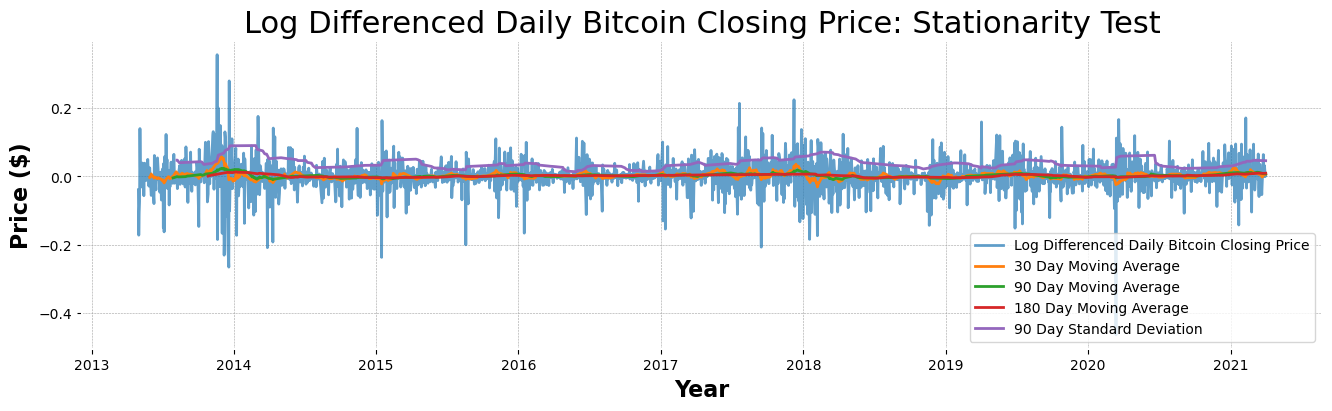

In [47]:
# visualize function on log diff data
stationarity_visualizer(log_diff['close'], 
                        'Log Differenced Daily Bitcoin Closing Price',
                       'Log Differenced Daily Bitcoin Closing Price: Stationarity Test')

The log-differenced visualization looks to be a more meaningful level stationarity in the data: the standard deviation shows little change over the entire data window. The compounded with the 30, 90, 180-day moving averages all showing little change over the entire data window, further suggesting stationarity.

A previously discussed pattern continues to be seen: when the data is treated with a linear trend there is minimal fluctuation in the data until 2018, but when the data is treated with an exponential trend there is much more fluctuation in the data throughout the entire window. This continues to validate the previous conclusion that the Bitcoin closing price data is exponentially trending because the residuals are consistently choppy throughout.

Based on our findings thusfar, we are able to begin to make a couple conclusions: the data is exponentially trending and the data needs to be differenced in order to achieve stationarity. Based on these findings an exponential model seems very appropriate. 

<a id="5"></a>
## Autocorrelation

___
Autocorrelation between Bitcoin closing price and lagged versions of itself will help confirm trends, seasonality, and better inform model selection. This section will explore autocorrelation with the `plot_acf` function instead of using the `autocorr` method for simplicity sake.

`plot_acf` shows us which day in the past correlates the most with the current day with respect to the days in between. If there are large, positive values for the first few lags this will further confirm a trend.

More details on what an ARIMA model is later, but it is important to note that the ACF chart helps estimate one of the inputs for the ARIMA model.

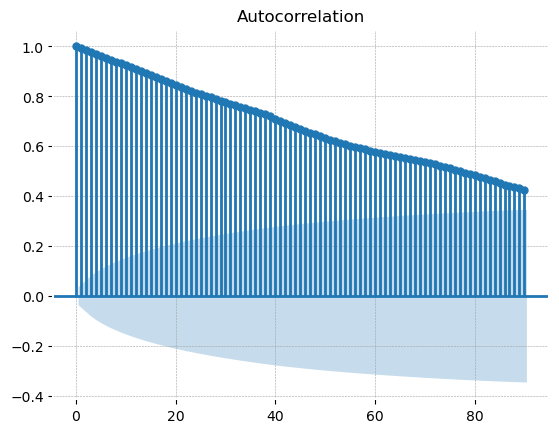

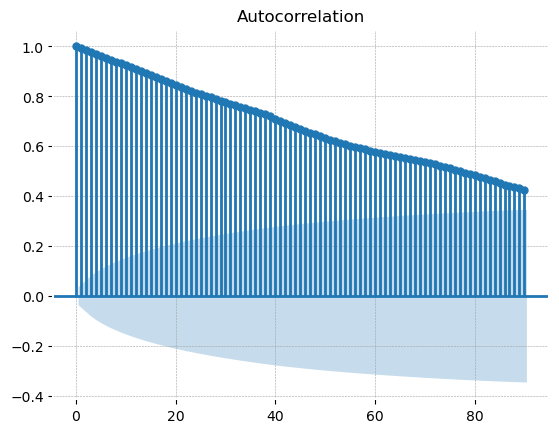

In [48]:
# plot daily ACF for one quarter
plot_acf(daily['close'], lags=90)

From the daily ACF chart there is significant correlation in the entire window that is shown (one full quarter of daily prices). The autocorrelation is above the blue shaded area (confidence interval) the entire time signaling the significance of these values. 

Given the high autocorrelation in the first few values, a trend is yet again confirmed in the data. There is no seasonality seen above but that is expected given the time period is a daily basis and no seasonality was seen at that level.

Despite all that can be seen, further exploration into the monthly ACF chart will be helpful.

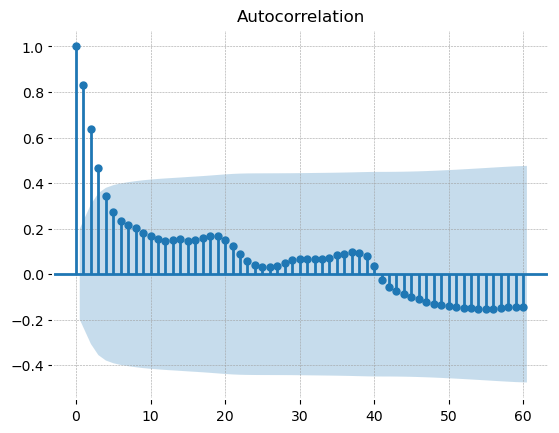

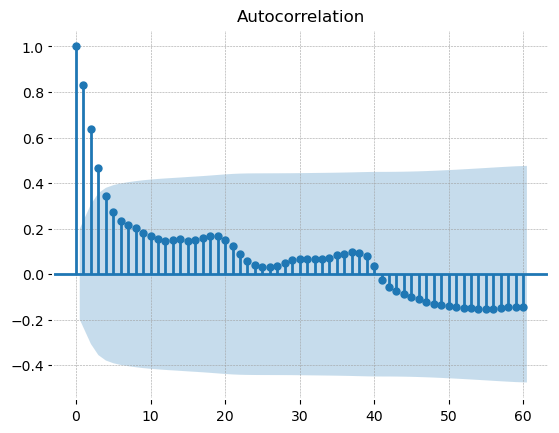

In [49]:
# plot monthly ACF for 5 years
plot_acf(daily['close'].resample('M').mean(), lags=60)

The monthly resampled ACF chart has two significant findings. First, the first few lags have significant autocorrelation signaling a trend on the monthly level. Second, the monthly resample looks to have a wave-like pattern signaling seasonality. We have previously confirmed seasonality at the monthly level so this further confirms the finding. The ACF charts have again confirmed a trend in the data and seasonality. 

The quarterly and semi-annual resampled ACF charts could not be created as there are not enough .

ACF charts are also helpful in determining if there is an autoregressive nature with the data: meaning the values will be regressed on older values in order to determine if there is a trend. As seen in the daily ACF Chart that spanned 90 days, at day 90 there was significant autocorrelation (above the blue shaded area). This suggests a long-term trend and validates the autoregressive nature of the data. This will be discussed in more detail later on, but this suggests exploring an ARIMA model could be helpful. 

<a id="6"></a>
## Partial-Autocorrelation

___
Partial-autocorrelation shows us which day in the past correlates directly to the current day by accounting for the days in between. The `plot_pacf` function visualizes this metric and can be called in a similar way as the `plot_acf` function. 

More details on what an ARIMA model is later, but it is important to note that the PACF chart helps estimate one of the inputs for the ARIMA model.

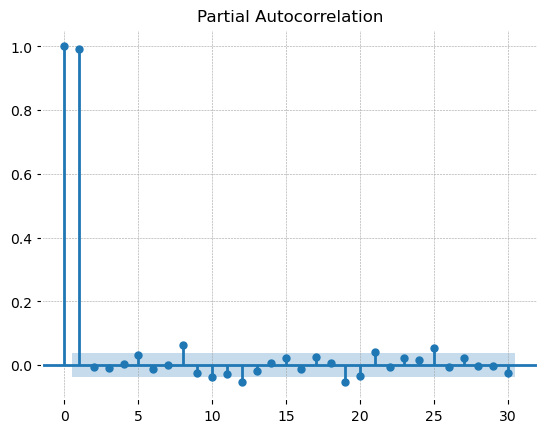

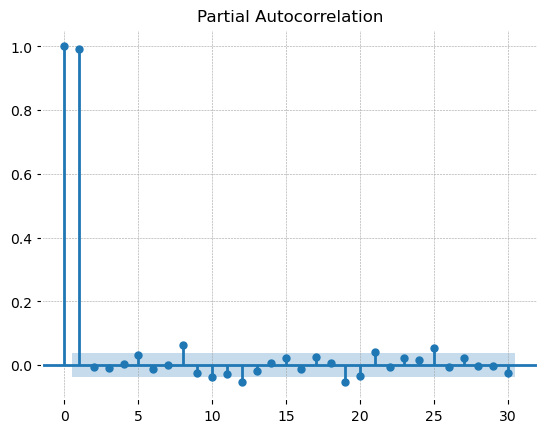

In [50]:
plot_pacf(daily['close'], lags=30)

In the PACF chart above has some significant findings. It is done on the daily Bitcoin closing price and each point outside of the blue shaded area (confidence interval: 95%) is a point of significance. There looks to be a slight pattern every 7-8 days which would be an indication of seasonality. This is the first indication of seasonality on a daily level. A deeper analysis into the monthly PACF charts will be helpful in understanding this deeper.

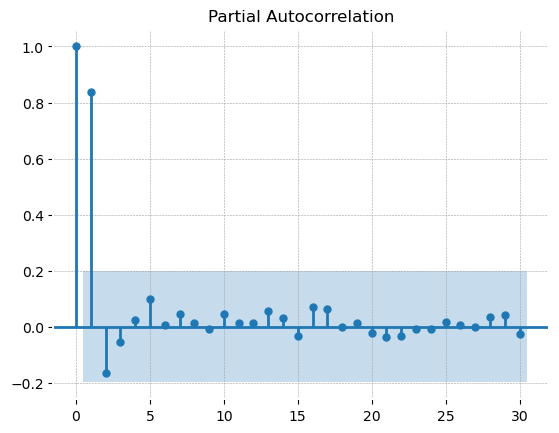

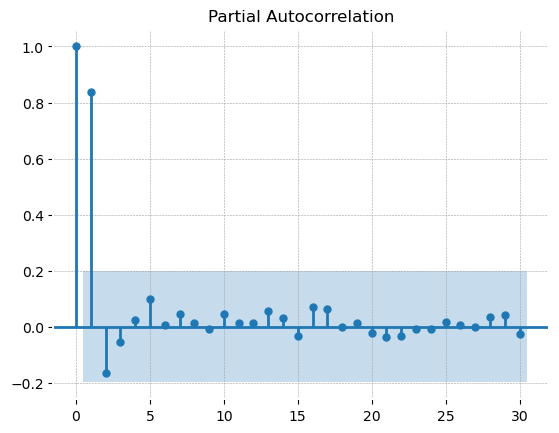

In [51]:
plot_pacf(daily['close'].resample('M').mean(), lags=30)

Both the monthly and quarterly PACF charts look very similar so only the monthly is being shown. Only one point on each chart is a point of significance, and it is always the first lag. The seasonality that was seen in other charts is not as clear here which may suggest the seasonality may not be of significance. It may be worth exploring models without seasonality to check this.

PACF charts are also helpful in determining if there is a need for a moving average incorporated into the model: meaning should the previous values impact future price. As with all financial data, previous price action does have an impact on future prices, however the degree in which the previous price action impacts future prices varies. The values of significance in the daily PACF chart suggest the moving average could be used to help forecast future Bitcoin prices. This again validates an ARIMA model (more on that later).

<a id="7"></a>
## Conclusions and Recommendations

___
Based on findings in EDA: the data has an exponential trend, the data is not stationary but a one-period differencing will allow the data to be stationary, there is seasonality in the data at the monthly level, and the data is highly correlated with past values.

Due to the exponential trend, exploring exponential smoothing models could make sense. Additionally, for the ARIMA models, the logged values should be used rather than the true values as stationarity was better achieved with the logges values. 

The differencing component is only critical to the ARIMA model as exponential models do not require stationarity. Based on findings above, the ARIMA model will then use the logged data rather than the true data in order to better achieve stationarity. There is an input value in an ARIMA model that factors in differencing and will be done automatically.

There are specified extensions to both exponential and ARIMA models that will help deal with seasonality. These models will also be explored to see if they can better forecast Bitcoin prices. 

The findings from the ACF and PACF help inform a few key inputs for both model types. 

Firstly, for the exponential smoothing models the smoothing level determines how much weight should be given to the most recent values. The exponential smoothing level is between 0 and 1 with 1 meaning the previous value is the next value and 0 means the most recent value has no impact on the next value. The ACF chart helps explain this: because the highest autocorrelation was seen in once lagged values, we can assume that the smoothing level should be closer to 1.

Next, for the exponential smoothing models the smoothing slope determines how much of the underlying trend needs to be smoothed out. It has a similar scale as the smoothing level (0 to 1) with the value of 1 meaning more smoothing is required. Because we were able to confirm the trend in the ACF chart, the smoothing level should be above 0, but determining what the appropriate level is will need to be searched over.

Finally, the ARIMA model has three key inputs: p, d, q. P is the autoregressive nature of the data. Given the ACF shows strong autocorrelation in the daily data, it would be safe to assume the autoregressive value would be higher given the high level of autocorrelation seen 90 days out. The D stands for differencing - this has been established that a value of one will suffice here. The Q is the moving average component of the data. The PACF chart showed significance in values every 7-8 time periods out (on the daily chart). From this finding it can be assumed that the moving average value would be above 0 due to this finding.

One final model that will be explored but has not yet been discussed is a recurrent neural network (RNN). This type of deep learning algorithm will be a separate model to the other model types that have been discussed. One of the key reasons that an RNN is being considered is due to the nature of deep learning models: instead of specifying the model parameters the RNN is able to take in the data and attempt to learn directly from it. Think of this process like removing the middleman of human [error] between the data and model. 

More details on each of these models can be found in their specified notebooks.

For those keeping score at home, the below is a streamlined explanation for each model and how justifications were reached:

ARIMA models:
- ARIMA (AutoRegressive, Integrated, Moving Average)

    - Confirmed autocorrelation, values could be very high given the autocorrelation seen at 90 lags out.
    - Confirmed differencing required for data to be stationary.
    - Confirmed moving average has been a line of support (50-day moving average) and the PACF chart confirmed a moving average will be useful in forecasting.
    
    
- SARIMA (same as ARIMA with seasonality incorporated)

    - Confirmed seasonality at a monthly level.

Exponential Smoothing:
- Double Exponential Smoothing
    
    - Confirmed data trend is exponential
    - Confirmed autocorrealtion
    
    
- Holt-Winters' Seasonal Method (same as Double Exponential Smoothing except with seasonality incorporated)

    - Confirmed seasonality at a monthly level.

Recurrent Neural Network:
- Allow the model to learn directly from the data rather than be told how to learn.